# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 20:41:22.609844: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 20:41:22.641678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 20:41:22.641778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 20:41:22.641830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 20:41:22.649083: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [4]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 151.23621535301208 seconds ---


In [5]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (164, 96)
y_test shape: (164,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (141, 2200)
y_test shape: (141,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (141, 96)
y_test shape: (141,)


## RNN-EBM


In [6]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=100,
    n_hidden=64,
    n_hidden_recurrent=128,
    min_lr=1e-3,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=32,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


2024-07-21 20:46:11.782881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:46:12.133070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:46:12.133916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

RNN-EBM training completed.


### Anomaly Detection

2024-07-21 20:48:58.470970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:48:58.472815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:48:58.473152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly prediction completed.


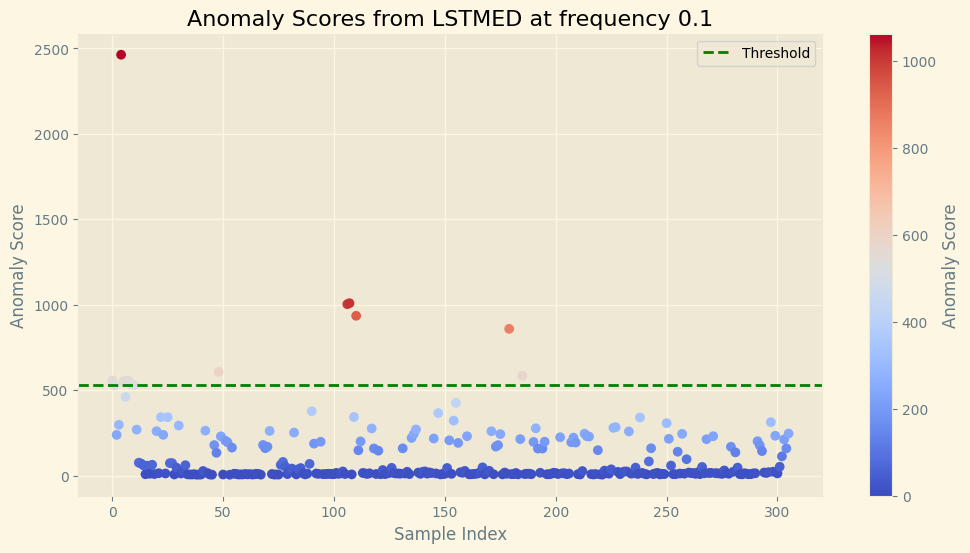

Number of anomalies detected: 12


2024-07-21 20:49:00.262021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:00.262195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:00.262268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly prediction completed.


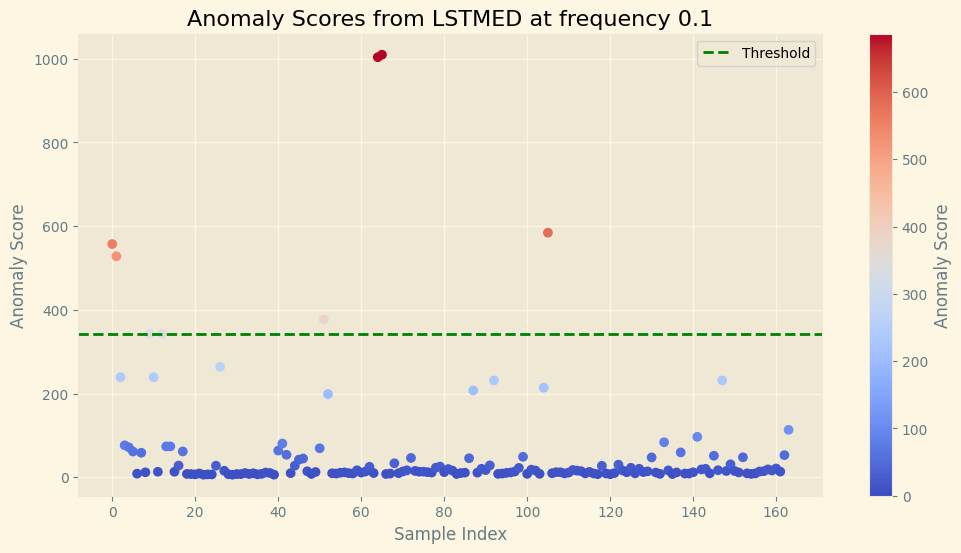

Number of anomalies detected: 6


2024-07-21 20:49:01.432160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:01.432458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:01.432526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly prediction completed.


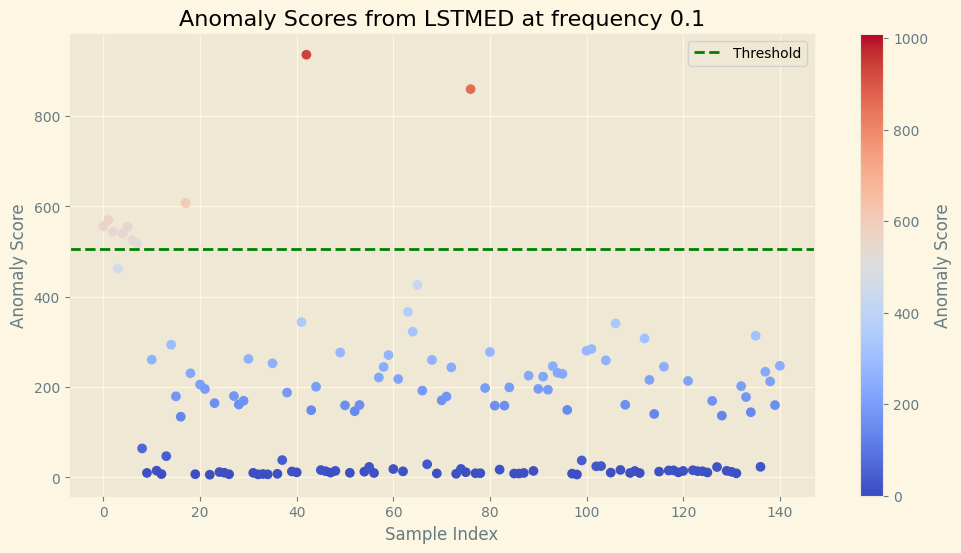

Number of anomalies detected: 10


In [7]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)
anomaly_scores1, anomalies_detected1 = plot_anomalies(classifier, X_test1, y_test1, freq)
anomaly_scores5, anomalies_detected5 = plot_anomalies(classifier, X_test5, y_test5, freq)

In [8]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)
anomaly_scores1, y_test_binary1 = compute_metrics(classifier, X_test1, y_test1)
anomaly_scores5, y_test_binary5 = compute_metrics(classifier, X_test5, y_test5)

2024-07-21 20:49:26.428484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:26.429562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:26.430107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly scores statistics:
Mean: 110.703369140625
Std: 210.1719970703125
Min: 5.997221946716309
Max: 2463.2568359375
ROC AUC Score: 0.9660
Detected anomaly class: 0
Threshold: 531.0474
F1 Score: 0.5000
Accuracy: 0.9608
Precision: 0.5000
Recall: 0.5000
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       294
           1       0.50      0.50      0.50        12

    accuracy                           0.96       306
   macro avg       0.74      0.74      0.74       306
weighted avg       0.96      0.96      0.96       306



2024-07-21 20:49:27.312361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:27.312627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:27.312730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly scores statistics:
Mean: 59.40248107910156
Std: 141.9894561767578
Min: 6.1435441970825195
Max: 1009.6282958984375
ROC AUC Score: 0.9710
Detected anomaly class: 0
Threshold: 343.3814
F1 Score: 0.4444
Accuracy: 0.9695
Precision: 0.3333
Recall: 0.6667
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       161
           1       0.33      0.67      0.44         3

    accuracy                           0.97       164
   macro avg       0.66      0.82      0.71       164
weighted avg       0.98      0.97      0.97       164



2024-07-21 20:49:28.035396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:28.036269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-21 20:49:28.036788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Anomaly scores statistics:
Mean: 157.3982391357422
Std: 173.728759765625
Min: 5.997221946716309
Max: 935.767822265625
ROC AUC Score: 0.9774
Detected anomaly class: 0
Threshold: 504.8558
F1 Score: 0.7778
Accuracy: 0.9716
Precision: 0.7000
Recall: 0.8750
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       133
           1       0.70      0.88      0.78         8

    accuracy                           0.97       141
   macro avg       0.85      0.93      0.88       141
weighted avg       0.98      0.97      0.97       141



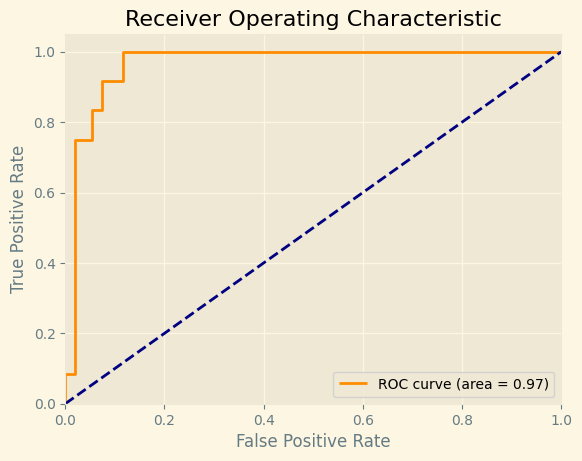

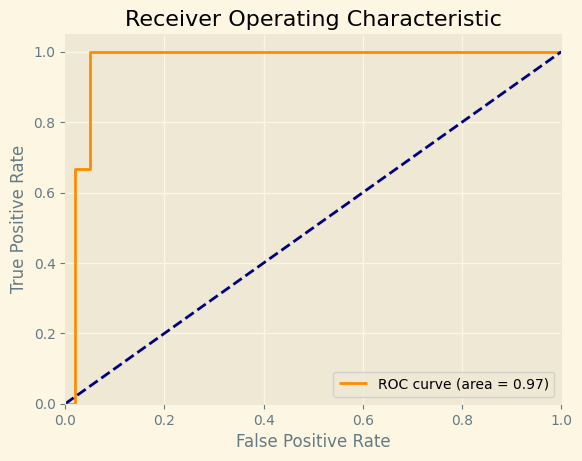

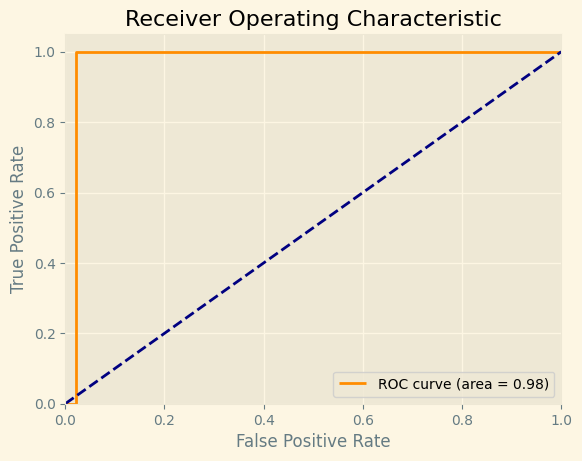

In [9]:
plot_roc_curve(y_test_binary, anomaly_scores)
plot_roc_curve(y_test_binary1, anomaly_scores1)
plot_roc_curve(y_test_binary5, anomaly_scores5)

## Map anomalies to original time series

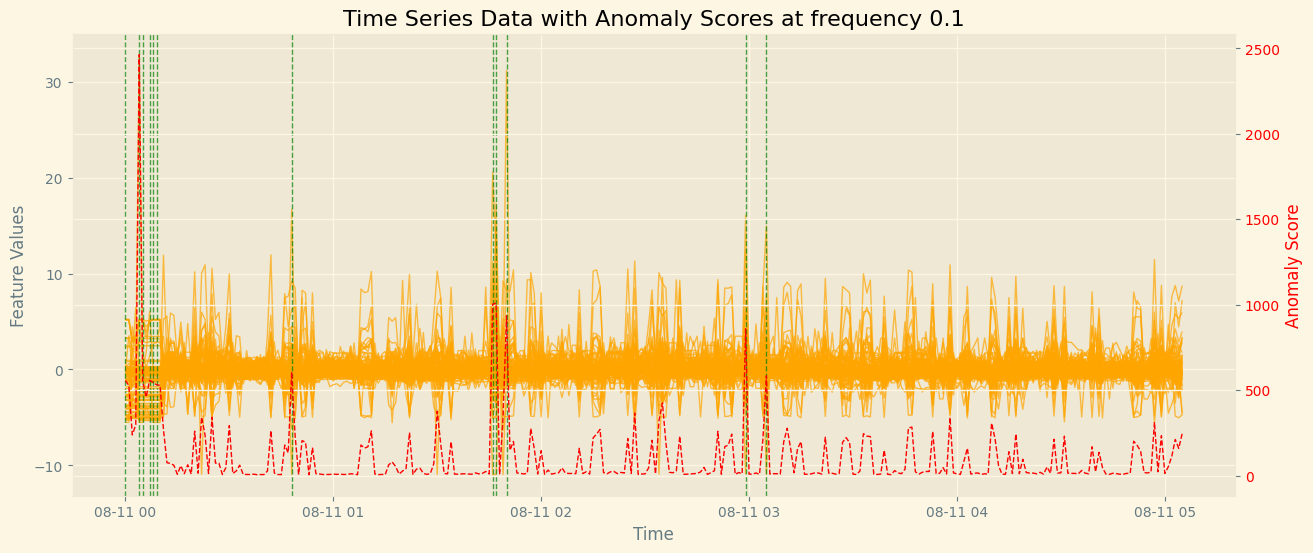

Top 12 Anomalies:
              timestamp  anomaly_score  \
4   2022-08-11 00:04:00    2463.256836   
107 2022-08-11 01:47:00    1009.628296   
106 2022-08-11 01:46:00    1003.689148   
110 2022-08-11 01:50:00     935.767822   
179 2022-08-11 02:59:00     859.585632   
48  2022-08-11 00:48:00     607.412354   
185 2022-08-11 03:05:00     584.458008   
7   2022-08-11 00:07:00     558.122192   
0   2022-08-11 00:00:00     557.303589   
5   2022-08-11 00:05:00     551.466064   
8   2022-08-11 00:08:00     545.895630   
9   2022-08-11 00:09:00     532.022583   

     machine_nameKuka Robot_apparent_power-_Average power  \
4                                            -5.323114      
107                                          -1.181816      
106                                          -1.885449      
110                                          -0.911260      
179                                          -1.338344      
48                                           -0.707436      
185     

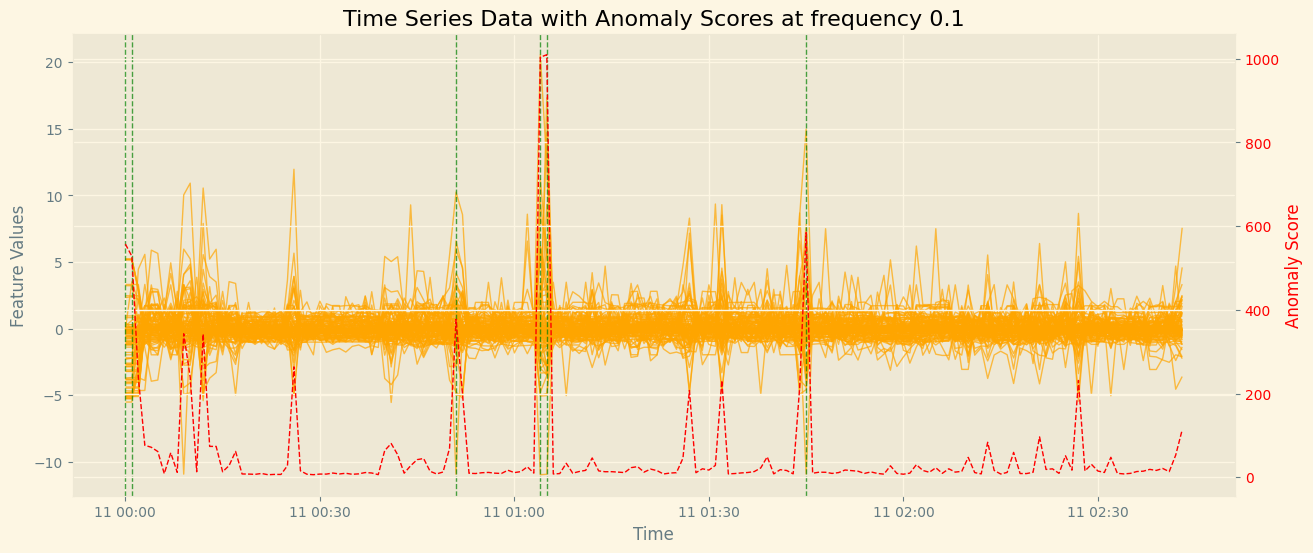

Top 6 Anomalies:
              timestamp  anomaly_score  \
65  2022-08-11 01:05:00    1009.628296   
64  2022-08-11 01:04:00    1003.689148   
105 2022-08-11 01:45:00     584.458008   
0   2022-08-11 00:00:00     557.303589   
1   2022-08-11 00:01:00     528.146667   
51  2022-08-11 00:51:00     377.350128   

     machine_nameKuka Robot_apparent_power-_Average power  \
65                                           -1.181816      
64                                           -1.885449      
105                                          -1.065886      
0                                            -5.248946      
1                                            -5.267211      
51                                           -1.115056      

     machine_nameKuka Robot_apparent_power-_Variance  \
65                                         -0.009713   
64                                         -0.170270   
105                                        -0.309507   
0                                   

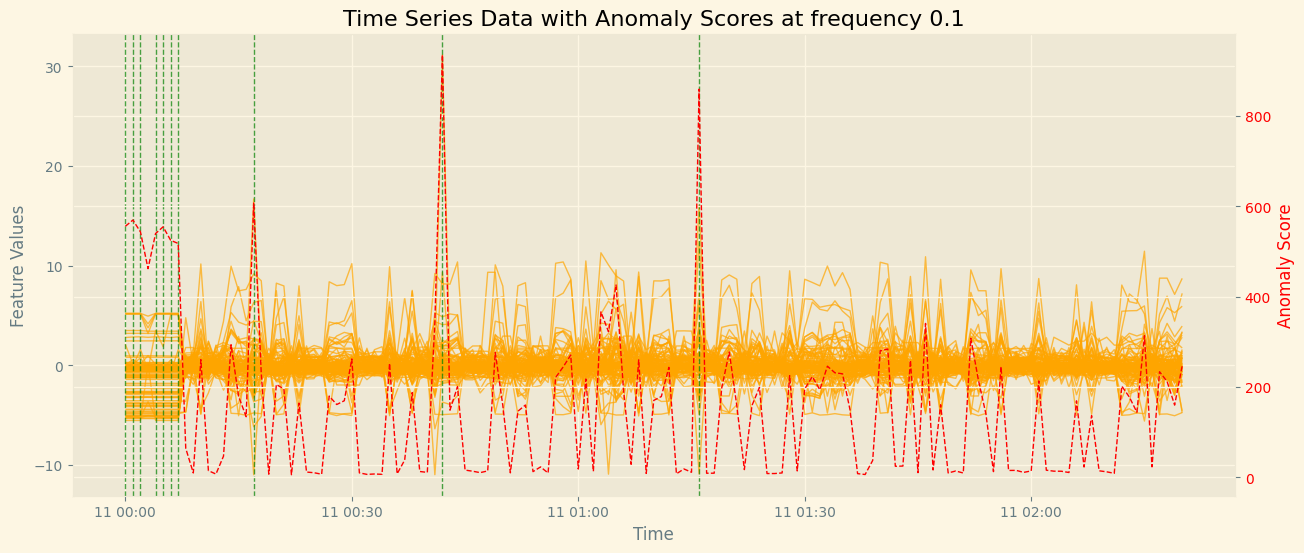

Top 10 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00     935.767822   
76 2022-08-11 01:16:00     859.585632   
17 2022-08-11 00:17:00     607.412354   
1  2022-08-11 00:01:00     569.812256   
0  2022-08-11 00:00:00     555.988098   
5  2022-08-11 00:05:00     554.777588   
2  2022-08-11 00:02:00     543.459778   
4  2022-08-11 00:04:00     539.879395   
6  2022-08-11 00:06:00     524.916626   
7  2022-08-11 00:07:00     517.859131   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      
1                                           -5.321892      
0                                           -5.315197      
5                                           -5.323855      
2                                           -5.322115      
4                                           -5.333

In [10]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)